<a href="https://colab.research.google.com/github/AndrewWalker251/recycling/blob/main/recycling_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recycling Object detector

References: 
*   https://pytorch.org/docs/stable/torchvision/models.html
*   Notebooks from Global Wheat Detection Kaggle challenge. 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


In [3]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 7.8MB/s 
     |████████████████████████████████| 952kB 8.0MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65164 sha256=b64625a9b7f7b2d34ffc859de727643db2d952aa0145dd8296d9d38b2b119030
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import ast
import torch
import torchvision
import cv2
from torchvision import transforms, datasets
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import SubsetRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader, Dataset

%matplotlib inline

from google.colab.patches import cv2_imshow

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [91]:
# Labelling completed via LabelBox. 
# Labelbox data needs some format converting to access required data (bounding box and class)
object_labels = pd.read_csv('recycling/labels_recycling.csv')
IMAGE_DIR = r'recycling/images'

# remove any images without any annotated objects
object_labels = object_labels[(object_labels['Label']).str.len() > 10]
object_labels.reset_index(inplace=True)

classes = {'cans':0, 'glass_bottles':1, 'plastic_bottles':2, 'paper':3, 'cardboard':4, 'tins': 5, 'plastic_containers':6}

# Unest JSON columns
df1 = pd.DataFrame(object_labels['Label'].apply(ast.literal_eval).values.tolist())
df2 = pd.DataFrame(df1['objects'].values.tolist())
df3 = pd.DataFrame(df2[0].values.tolist())
df4 = pd.DataFrame(df3['bbox'].values.tolist())
df = pd.concat([df4, df3['value'] ,object_labels['External ID']],axis=1)
df['value_id'] = df['value'].replace(classes)
df.dropna(inplace=True)
df.reset_index(inplace=True)

In [14]:
df['value'].unique()

array(['cans', 'glass_bottles', 'plastic_bottles', 'paper', 'cardboard',
       'tins', 'plastic_containers'], dtype=object)

In [15]:
df.head()

,index,top,left,height,width,value,External ID,value_id
0,0,224,16,181,272,cans,PXL_20201207_080550115.jpg,0
1,1,228,107,163,109,cans,PXL_20201207_080405852.jpg,0
2,2,94,167,278,113,glass_bottles,PXL_20201207_080604623.jpg,1
3,3,266,163,129,62,glass_bottles,PXL_20201207_080612751.jpg,1
4,4,176,155,265,121,plastic_bottles,PXL_20201207_080437597.jpg,2


In [16]:
# Modify Pytorch dataset class for object detection 

class RecyclingDataset(Dataset):

    '''
    Pytorch Dataset Class updated for recycling project
    Methods created to return image and labels.
    '''
    
    def __init__(self, dataframe, image_dir, transforms):
        super().__init__()
        
        '''
        inputs - dataframe: provides data for boxes and labels ['top'	'left'	'height'	'width'	'value'	'External ID'	'value_id']
        image_dir - location where images are saved
        transforms - required transforms for images.    
        '''
        self.image_ids = dataframe['External ID'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index):

        '''
        inputs
        index: index of image to be returned
        outputs
        image
        targets - dictionary of boxes, labels and area
        '''
        
        image_id = self.image_ids[index]
        records = self.df[self.df['External ID'] ==image_id]
        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /=255.0
        
        # Box coordinates
        boxes = records[['left', 'top','width', 'height']].values
        area = boxes[:,2] * boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)

        # convert to corners of box
        boxes[:,2] = boxes[:,0] + boxes[:,2]
        boxes[:,3] = boxes[:,1] + boxes[:,3]
        
        labels = records['value_id'].values
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area']= area
        
        if self.transforms:
            sample = {
                'image':image,
                'bboxes':target['boxes'],
                'labels':labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0).float()
            target['labels'] = torch.from_numpy(labels).long()

        return image, target
        
    def __len__(self):
        return self.image_ids.shape[0]
        

In [17]:
# Albumentations library for transfors.
def get_transforms():
    '''
    Uses the albulmentations library to transform images.
    Same transforms used for train and test
    Only uses resize for now.
    '''
    return A.Compose([
        A.Resize(200, 300),
        ToTensorV2(p=1.0)], bbox_params = {'format':'pascal_voc', 'label_fields': ['labels']})


In [18]:
# Create instance of custom dataset. 
myrecycleloader = RecyclingDataset(df, IMAGE_DIR, get_transforms())

In [44]:
len(myrecycleloader)

192

In [19]:
def collate_fn(batch):
  return tuple(zip(*batch))

In [47]:
def create_separate_train_dev_test( dataset, percentages = [0.8, 0, 0.2]):
    '''
    Function to create separate dataloaders for test dev and train.
    
    Inputs - list of percentage breakdowns [train, dev , test] Must add to 1. 
    #TODO Add in test to check for this ~
    
    Outputs - each dataloader.
    '''

    indices = list(range(len(dataset)))
    train_amount =0.8
    dev = 0.1
    test = 0.1

    split_1 = int(np.floor(len(dataset)*0.8))
    split_2 = int(np.floor(len(dataset)*0.9))

    np.random.seed(0)
    np.random.shuffle(indices)

    train_indices, dev_indices, test_indices = indices[:split_1], indices[split_1:split_2],indices[split_2:]

    train_sampler = SubsetRandomSampler(train_indices)
    dev_sampler = SubsetRandomSampler(dev_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    dataloader_train = torch.utils.data.DataLoader(dataset,
                                                 batch_size=10,
                                                 num_workers=0 , sampler = train_sampler, collate_fn = collate_fn)

    dataloader_dev = torch.utils.data.DataLoader(dataset,
                                                 batch_size=1,
                                                 num_workers=0 , sampler = dev_sampler, collate_fn = collate_fn)

    dataloader_test = torch.utils.data.DataLoader(dataset,
                                                 batch_size=2,
                                                 num_workers=0 , sampler = test_sampler,collate_fn = collate_fn)
    
    return dataloader_train, dataloader_dev, dataloader_test

In [48]:
dataloader_train, dataloader_dev, dataloader_test = create_separate_train_dev_test( myrecycleloader, percentages = [0.7,0,0.3])

In [46]:
len(dataloader_test)

20

In [24]:
# Visualise output from dataloader.
images, targets = next(iter(dataloader_train))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
targets

[{'area': tensor([109782.], device='cuda:0'),
  'boxes': tensor([[ 49.2188,  61.3281, 300.0000, 194.9219]], device='cuda:0'),
  'labels': tensor([4], device='cuda:0')},
 {'area': tensor([25400.], device='cuda:0'),
  'boxes': tensor([[110.1562,  89.4531, 209.3750, 167.5781]], device='cuda:0'),
  'labels': tensor([2], device='cuda:0')},
 {'area': tensor([77520.], device='cuda:0'),
  'boxes': tensor([[ 60.1562,  51.5625, 219.5312, 200.0000]], device='cuda:0'),
  'labels': tensor([4], device='cuda:0')},
 {'area': tensor([32606.], device='cuda:0'),
  'boxes': tensor([[ 57.8125,  54.6875, 150.7812, 161.7188]], device='cuda:0'),
  'labels': tensor([4], device='cuda:0')},
 {'area': tensor([21976.], device='cuda:0'),
  'boxes': tensor([[141.4062, 100.0000, 246.0938, 164.0625]], device='cuda:0'),
  'labels': tensor([0], device='cuda:0')},
 {'area': tensor([101671.], device='cuda:0'),
  'boxes': tensor([[ 71.0938,  44.5312, 300.0000, 180.0781]], device='cuda:0'),
  'labels': tensor([6], device='c

In [25]:
def plot_object_and_box(img, objects, idx):
  '''
  Plot image with actual boxes. 

  inputs
  img - batch of images
  objects - actual batch of targets
  idx - index of image in batch
  '''
  
  box = objects[idx]['boxes'].cpu().numpy().astype(np.int32)

  xmin = box[0][0]
  ymin = box[0][1]
  xmax = box[0][2]
  ymax = box[0][3]

  image = img[idx].permute(1,2,0).cpu().numpy()
  fig, ax = plt.subplots(1,1,figsize = (8,4))
  ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color= 'red', linewidth=3))
  for key, value in classes.items(): 
         if value == targets[idx]['labels'].cpu().numpy()[0]: 
             class_label =  key

  ax.text(xmin, ymin, class_label,color='red', fontsize=16)

  ax.imshow(image)
  plt.show()

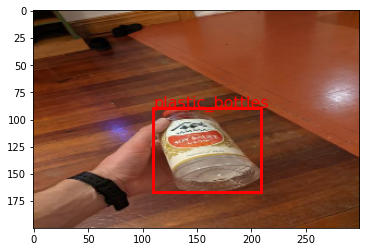

In [26]:
# Plot example of training data
plot_object_and_box(images, targets, 1)

In [27]:
# Pytorch pretrained faster RCNN with ResNet50 backbone. 
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [28]:
# Correct the head of the model for our domain 
# Retain most of the model as previously trained.
num_classes = 7
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [29]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum =0.9, weight_decay=0.0005)

In [ ]:
 Training
for epoch in range(30):
  for images, targets in dataloader_train:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    print(losses.item())

In [30]:
# Save latest model if required.
PATH = './model_weights.pth'
#torch.save(model.state_dict(), PATH)

In [31]:
# Load last model if not training.
if device.type == 'cpu':
  model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
else:
  model.load_state_dict(torch.load(PATH))

In [32]:
def plot_object_and_box_eval(img, objects, actual, idx):
  '''
  Plot image with actual and predicted boxes. 

  inputs
  img - batch of images
  objects - batch of predictions
  actual - batch of actual targets 
  idx - index of image in batch
  '''

  fig, ax = plt.subplots(1,1,figsize = (8,4))

  box = objects[idx]['boxes'].cpu().detach().numpy().astype(np.int32)

  # There are multiple predictions per image. This set up only graphs one object
  # per image. The one that's most likely. If we wanted two objects above a certain threshold we
  # would need to change this code. 
  xmin = box[0][0]
  ymin = box[0][1]
  xmax = box[0][2]
  ymax = box[0][3]

  ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color= 'red', linewidth=3))
  
  for key, value in classes.items(): 
         if value == objects[idx]['labels'].cpu().numpy()[0]: 
             class_label =  key + '_predicted'

  ax.text(xmin, ymin, class_label,color='red', fontsize=16)
  
  box = actual[idx]['boxes'].cpu().detach().numpy().astype(np.int32)

  xmin = box[0][0]
  ymin = box[0][1]
  xmax = box[0][2]
  ymax = box[0][3]

  ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color= 'green', linewidth=3))
  
  for key, value in classes.items(): 
         if value == actual[idx]['labels'].cpu().numpy()[0]: 
             class_label =  key + '_actual'

  ax.text(xmax, ymax, class_label,color='green', fontsize=16)

  image = img[idx].permute(1,2,0).cpu().numpy()
  
  
  ax.imshow(image)
  plt.show()

In [33]:
torch.cuda.empty_cache()

In [50]:
for images, actual in dataloader_test:
  images = list(image.to(device) for image in images)
  actual = [{k: v.to(device) for k, v in t.items()} for t in actual]
  actual[0]['labels'].cpu().numpy()[0]

  #print(images)
  print(actual)
  print('just one')
  print(actual[0]['labels'])
  print(actual[0]['labels'].cpu().numpy()[0])

[{'boxes': tensor([[ 75.0000,  85.1562, 161.7188, 163.6719]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'area': tensor([22311.], device='cuda:0')}, {'boxes': tensor([[107.0312,  33.5938, 235.1562, 164.0625]], device='cuda:0'), 'labels': tensor([6], device='cuda:0'), 'area': tensor([54776.], device='cuda:0')}]
just one
tensor([2], device='cuda:0')
2
[{'boxes': tensor([[ 80.4688,  83.2031, 209.3750, 152.3438]], device='cuda:0'), 'labels': tensor([6], device='cuda:0'), 'area': tensor([29205.], device='cuda:0')}, {'boxes': tensor([[ 74.2188,  21.4844, 207.0312, 169.9219]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'area': tensor([64600.], device='cuda:0')}]
just one
tensor([6], device='cuda:0')
6
[{'boxes': tensor([[ 54.6875,  79.6875, 258.5938, 200.0000]], device='cuda:0'), 'labels': tensor([5], device='cuda:0'), 'area': tensor([80388.], device='cuda:0')}, {'boxes': tensor([[ 57.0312,  53.5156, 290.6250, 198.4375]], device='cuda:0'), 'labels': tensor([4], d

In [ ]:
for images, actual in dataloader_test:
  print(images)
  images = list(image.to(device) for image in images)
  print(images)
  print(actual)
  model.eval()
  outputs = model(images)
  print(outputs)
  break

(tensor([[[0.1447, 0.0893, 0.0967,  ..., 0.6697, 0.7003, 0.6559],
         [0.1776, 0.0917, 0.0858,  ..., 0.6904, 0.6953, 0.6553],
         [0.2672, 0.1253, 0.0765,  ..., 0.6957, 0.6885, 0.6732],
         ...,
         [0.5861, 0.5844, 0.5869,  ..., 0.2728, 0.2706, 0.2709],
         [0.6380, 0.6319, 0.6253,  ..., 0.2667, 0.2674, 0.2680],
         [0.6449, 0.6410, 0.6371,  ..., 0.2667, 0.2644, 0.2627]],

        [[0.0673, 0.0208, 0.0389,  ..., 0.6069, 0.6376, 0.5932],
         [0.1124, 0.0367, 0.0395,  ..., 0.6276, 0.6326, 0.5925],
         [0.2280, 0.0931, 0.0416,  ..., 0.6329, 0.6258, 0.6104],
         ...,
         [0.3355, 0.3372, 0.3355,  ..., 0.1395, 0.1373, 0.1376],
         [0.3675, 0.3664, 0.3607,  ..., 0.1333, 0.1341, 0.1347],
         [0.3626, 0.3586, 0.3553,  ..., 0.1333, 0.1311, 0.1294]],

        [[0.0743, 0.0218, 0.0361,  ..., 0.5481, 0.5788, 0.5344],
         [0.1068, 0.0215, 0.0224,  ..., 0.5688, 0.5737, 0.5337],
         [0.1890, 0.0510, 0.0051,  ..., 0.5741, 0.5670, 0

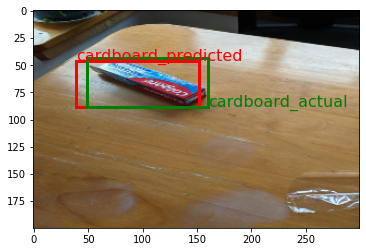

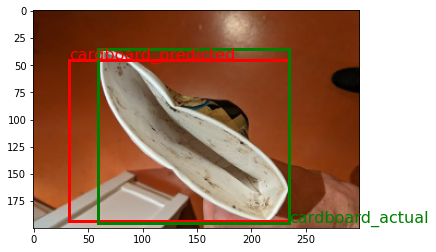

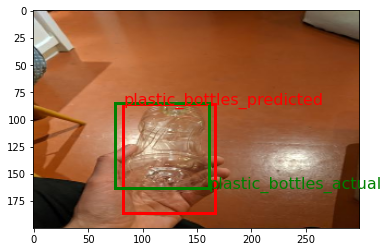

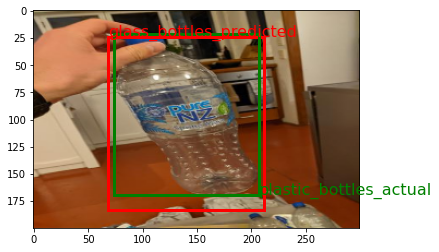

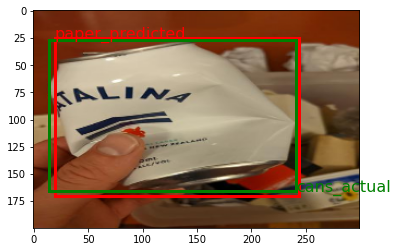

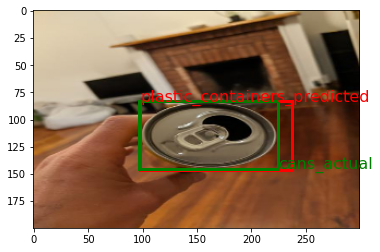

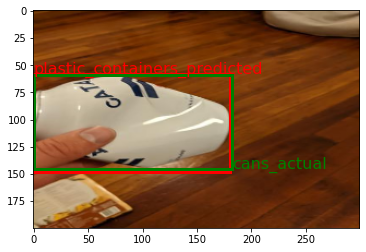

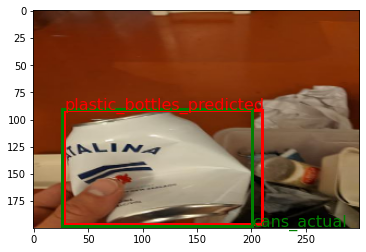

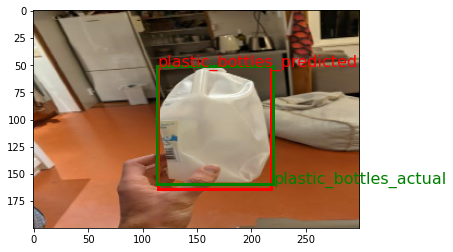

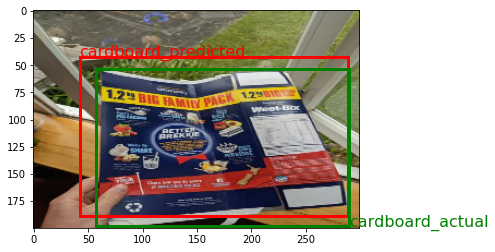

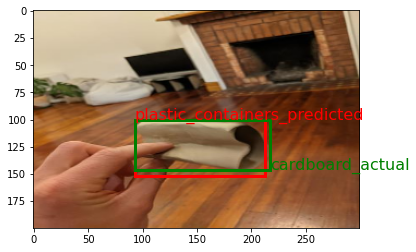

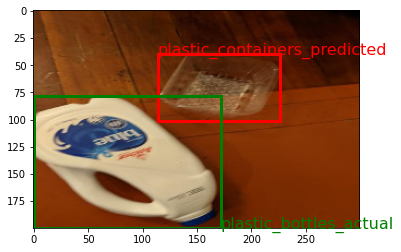

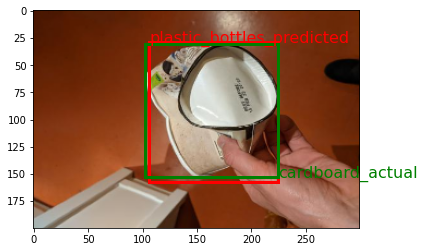

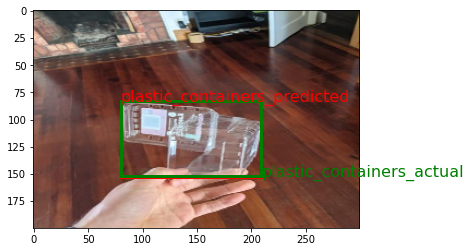

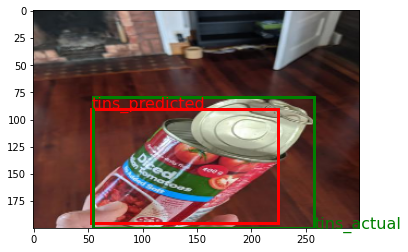

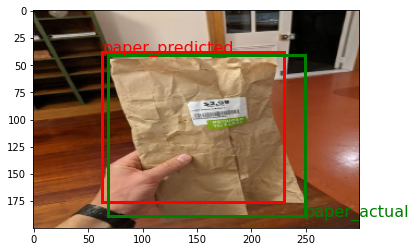

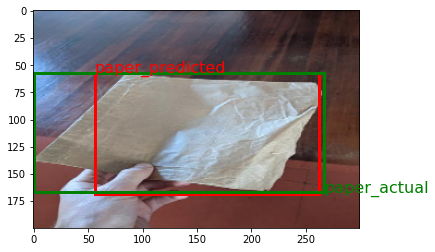

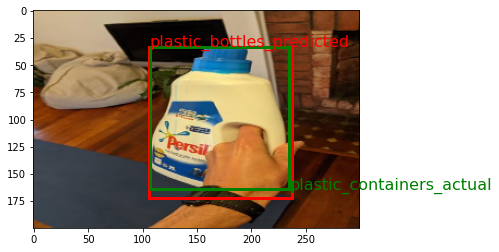

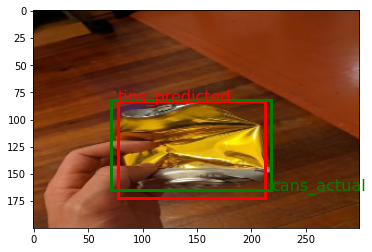

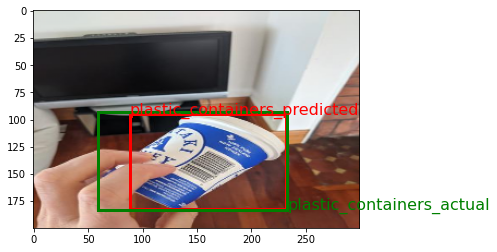

In [105]:
# I want to store predictions so I can make a 

actual_ids = []
prediction_ids = []

# Predict boxes for all images in test set and plot the results. 
for images, actual in dataloader_test:

  # remember whilst batch = 1 for test this is unrequired. 
  images = list(image.to(device) for image in images)
  actual = [{k: v.to(device) for k, v in t.items()} for t in actual]
  for actual_prediction in actual:
    actual_number = actual_prediction['labels'].cpu().numpy()[0]
    actual_ids.append(actual_number)

  # for this way of doing it you want the batch size for your test to always be 1.

  model.eval()
  outputs = model(images)
  outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
  for output_prediction in outputs:
    predicted_number = output_prediction['labels'].cpu().numpy()[0]
    prediction_ids.append(predicted_number)

  # with a batch of 1 this isn't actually required as there's only 1. 
  # It also only prints out 1 object - the most likely 
  # If there's more than one object it currently wont guess more than 1. 
  for i in range(0,len(outputs)):
    plot_object_and_box_eval(images, outputs, actual, i)
  
df_results = pd.DataFrame({'actual': actual_ids,
                           'predictions': prediction_ids})

In [106]:
 classes_reverse = {0: 'cans', 1: 'glass_bottles', 2:'plastic_bottles', 3:'paper', 4:'cardboard', 5:'tins', 6:'plastic_containers'}

In [107]:
from sklearn.metrics import confusion_matrix

In [108]:
cf_matrix = confusion_matrix(df_results['actual'], df_results['predictions'], normalize=None)

In [109]:
cf_matrix

array([[0, 0, 1, 1, 0, 1, 2],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 1, 2, 0, 0, 0, 1],
       [0, 0, 0, 2, 0, 0, 0],
       [0, 0, 1, 0, 3, 0, 1],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 2]])

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

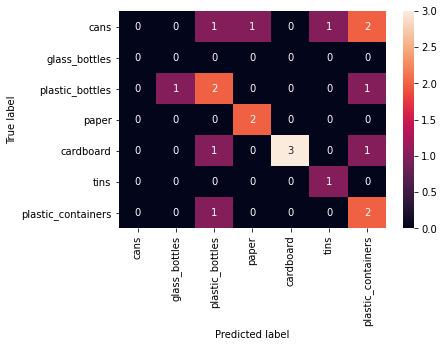

In [121]:
import matplotlib.pyplot as plt     

ax= plt.subplot()
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, ax=ax)
plt.ylabel('True label')
plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['cans', 'glass_bottles', 'plastic_bottles', 'paper', 'cardboard', 'tins', 'plastic_containers']); ax.yaxis.set_ticklabels(['cans', 'glass_bottles', 'plastic_bottles', 'paper', 'cardboard', 'tins', 'plastic_containers'])
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)